# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 1. Подготовка данных

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as ltb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Проверим данные на наличие дуликатов, и если они есть, то удалим их.

In [67]:
df.duplicated().sum()

4

In [68]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Посмотрим как распределены цены на автомобили.

In [69]:
df.groupby('Price')['Price'].count()

Price
0        10772
1         1189
2           12
3            8
4            1
         ...  
19995       10
19997        1
19998        6
19999      278
20000      268
Name: Price, Length: 3731, dtype: int64

Так же посмотрим на цены на графике.

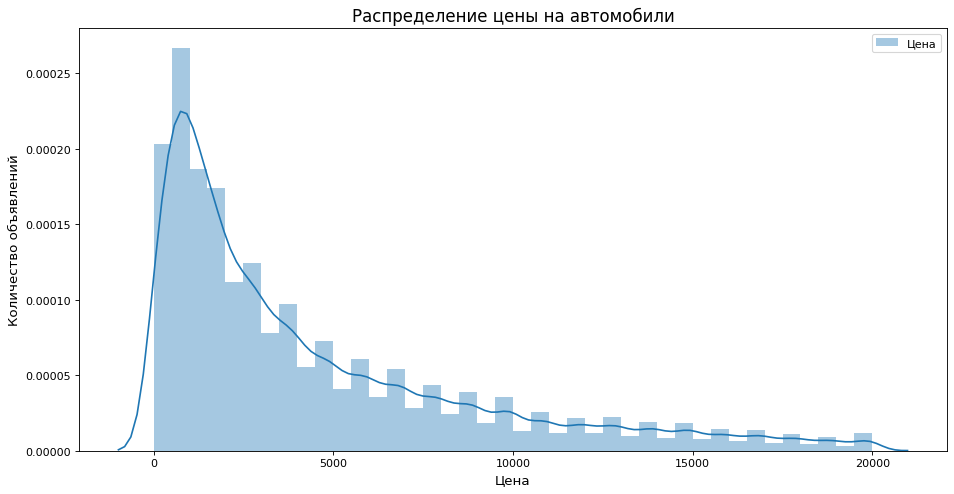

In [70]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df['Price'], label='Цена', bins=40)

plt.legend()
plt.title('Распределение цены на автомобили', fontsize=15)
plt.ylabel('Количество объявлений', fontsize=12)
plt.xlabel('Цена', fontsize=12)
plt.show()

In [71]:
# заменим нули на значение "unknown"
df['Price'] = df['Price'].replace(0, 'unknown')
df = df.query('Price != "unknown"')

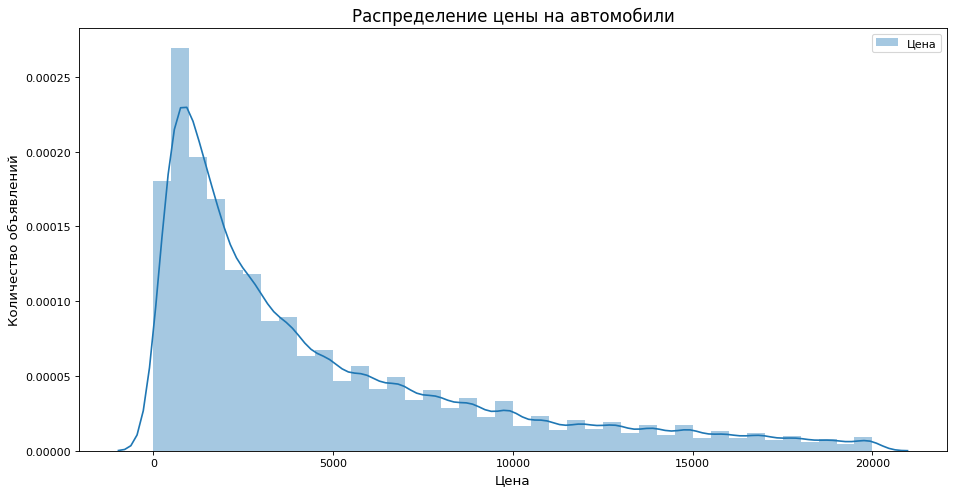

In [72]:

plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df['Price'][df['Price'] != 'unknown'], label='Цена', bins=40)

plt.legend()
plt.title('Распределение цены на автомобили', fontsize=15)
plt.ylabel('Количество объявлений', fontsize=12)
plt.xlabel('Цена', fontsize=12)
plt.show()

Как видно, график имеет логнормальное распределение, что в целом характерно для денежных единиц.

Теперь рассмотрим колонку `RegistrationYear`.

In [73]:
df.groupby('RegistrationYear')['RegistrationYear'].count()

RegistrationYear
1000    31
1001     1
1039     1
1111     1
1234     4
        ..
8500     1
8888     1
9000     2
9450     1
9999    18
Name: RegistrationYear, Length: 140, dtype: int64

В данных прсутствуют ошибочные значения, например после 2019 года, это будет наша верхняя граница, а нижнюю возьмем 1950, уберем данные вне этих границ.

In [74]:
df = df.query('1950 <= RegistrationYear <= 2019')
df.groupby('RegistrationYear')['RegistrationYear'].count()

RegistrationYear
1950      17
1951      10
1952       8
1953      14
1954       9
        ... 
2015    1243
2016    8968
2017    9895
2018    3782
2019      16
Name: RegistrationYear, Length: 70, dtype: int64

Теперь данные более корректные.

Перейдем к рассмотрению колонки `Power`.

In [75]:
df.groupby('Power')['Power'].count()

Power
0        36180
1           26
2            9
3            8
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 699, dtype: int64

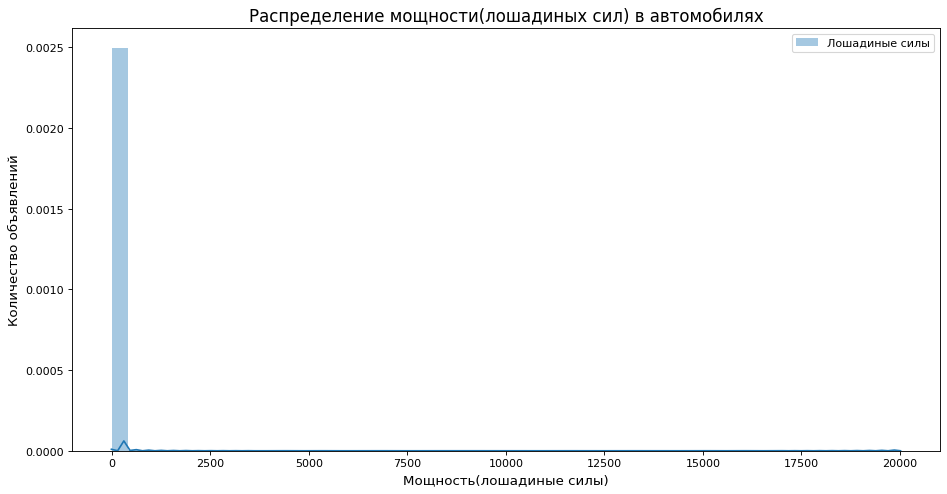

In [76]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df['Power'], label='Лошадиные силы')

plt.legend()
plt.title('Распределение мощности(лошадиных сил) в автомобилях', fontsize=15)
plt.ylabel('Количество объявлений', fontsize=12)
plt.xlabel('Мощность(лошадиные силы)', fontsize=12)
plt.show()

Проведя поиск максимального количества "лошадиных сил" в машине, и которая имеет серийное производство, была найдена Hennessey Venom F5, Mercedes-Benz SLR McLaren V10 и Lamborghini Aventador LP с количеством 1600 л.с. <br/>https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire <br/> Возьмем эту границу для отсечения данных сверху, а для низа значения больше 0.
    

In [77]:
df = df.query('0 < Power <= 1600')
df.groupby('Power')['Power'].count()

Power
1        26
2         9
3         8
4        30
5       101
       ... 
1595      2
1596      1
1597      1
1598      7
1600      3
Name: Power, Length: 563, dtype: int64

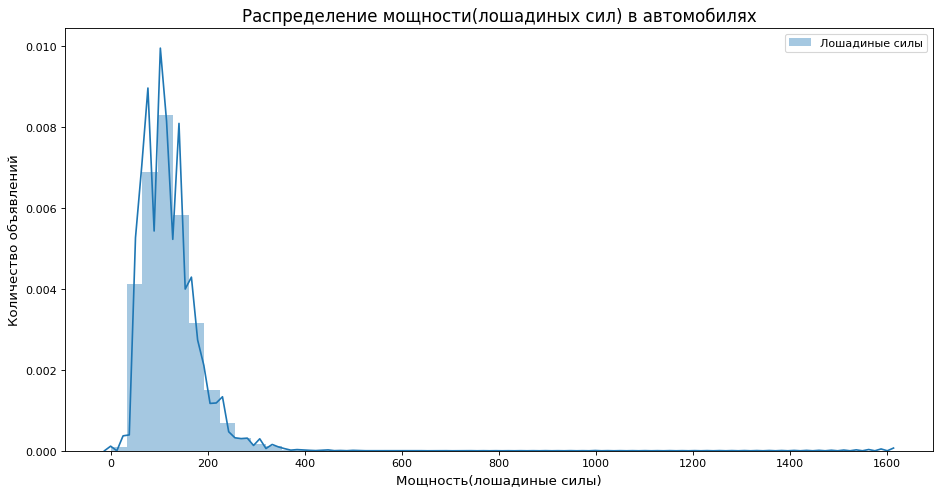

In [78]:
plt.figure(figsize=(14,7), dpi= 80)

sns.distplot(df['Power'], label='Лошадиные силы')

plt.legend()
plt.title('Распределение мощности(лошадиных сил) в автомобилях', fontsize=15)
plt.ylabel('Количество объявлений', fontsize=12)
plt.xlabel('Мощность(лошадиные силы)', fontsize=12)
plt.show()

Проверим значения в колонке `Kilometer`.

In [79]:
df.groupby('Kilometer')['Kilometer'].count()

Kilometer
5000        3086
10000        951
20000       3398
30000       4004
40000       4590
50000       5801
60000       6974
70000       7990
80000       9286
90000      10586
100000     13194
125000     32886
150000    204238
Name: Kilometer, dtype: int64

В этой колонке со значениями всё впорядке.

In [80]:
# так же заменим все Nan значения на маркеры
df = df.fillna('unknown')

# используем столбец с датами для расчета возраста автомобиля
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
# выделим год из даты
df['Year_Created'] = pd.DatetimeIndex(df['DateCreated']).year
df['Years_Car'] = df['Year_Created'] - df['RegistrationYear']

# выделим из столбца PostalCode первые 2 цифры, для признака географии
df['PostalCode'] = df['PostalCode'] // 1000

# удалим столбцы, которые в будущем не понадобятся
df = (df
      .drop(['DateCrawled', 'DateCreated', 'LastSeen', 'Year_Created', 'RegistrationYear', 'RegistrationMonth'], axis=1)
      .reset_index(drop=True))
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306984 entries, 0 to 306983
Data columns (total 12 columns):
Price               306984 non-null int64
VehicleType         306984 non-null object
Gearbox             306984 non-null object
Power               306984 non-null int64
Model               306984 non-null object
Kilometer           306984 non-null int64
FuelType            306984 non-null object
Brand               306984 non-null object
NotRepaired         306984 non-null object
NumberOfPictures    306984 non-null int64
PostalCode          306984 non-null int64
Years_Car           306984 non-null int64
dtypes: int64(6), object(6)
memory usage: 28.1+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Years_Car
0,18300,coupe,manual,190,unknown,125000,gasoline,audi,yes,0,66,5
1,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,0,90,12
2,1500,small,manual,75,golf,150000,petrol,volkswagen,no,0,91,15
3,3600,small,manual,69,fabia,90000,gasoline,skoda,no,0,60,8
4,650,sedan,manual,102,3er,150000,petrol,bmw,yes,0,33,21
...,...,...,...,...,...,...,...,...,...,...,...,...
306979,5250,unknown,auto,150,159,150000,unknown,alfa_romeo,no,0,51,0
306980,3200,sedan,manual,225,leon,150000,petrol,seat,yes,0,96,12
306981,1199,convertible,auto,101,fortwo,125000,petrol,smart,no,0,26,16
306982,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no,0,87,20


In [82]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
cod = df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]
df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.fit_transform(cod)
df = df.astype('int')

### Вывод

Проведя предобработку данных мы сделали следующее:
- проверили и удалили дубликаты;
- убрали строчки, где года были не корректны, до 1950 и после 2019;
- где строчки с мощностью, лошадинные силы, были равны нулю;
- заменили нули в колонке `Price` и значения `Nan` на маркер `unknown`;
- посчитали возраст автомобилей;
- выделили "географию" из почтового индекса;
- закодировали данные для обучения.

## 2. Обучение моделей

Подготовим features и target для обучения и проверок моделей.

In [83]:
features = df.drop(['Price'], axis=1)
target = df['Price']

In [84]:
# разделим выборку на train и test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [85]:
# создадим таблицу для внесения результатов моделей
#columns = ['model','fit_time','predict_time', 'RMSE']
mod_columns = {'model':[],'fit_time':[],'predict_time':[], 'RMSE':[]}
df_model = pd.DataFrame(mod_columns)

In [86]:
features

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Years_Car
0,2,1,190,227,125000,2,1,2,0,66,5
1,6,0,163,117,125000,2,14,1,0,90,12
2,5,1,75,116,150000,6,38,0,0,91,15
3,5,1,69,101,90000,2,31,0,0,60,8
4,4,1,102,11,150000,6,2,2,0,33,21
...,...,...,...,...,...,...,...,...,...,...,...
306979,7,0,150,4,150000,7,0,0,0,51,0
306980,4,1,225,140,150000,6,30,2,0,96,12
306981,1,0,101,106,125000,6,32,0,0,26,16
306982,0,1,102,223,150000,2,38,0,0,87,20


Будем использовать 3 модели для обучения: RandomForestRegressor, LGBMRegressor и LinearRegression.

In [88]:
model_forest = RandomForestRegressor(random_state=32)

x = datetime.datetime.now()
model_forest.fit(features_train, target_train)
time_of_fit_forest = (datetime.datetime.now()-x).microseconds

x = datetime.datetime.now()
predict_forest = model_forest.predict(features_test)
time_of_pred_forest = (datetime.datetime.now()-x).microseconds

rmse_forest = '{:.3f}'.format(mean_squared_error(target_test, predict_forest)**0.5)

row = {'model':'RandomForestRegressor', 'fit_time':time_of_fit_forest, 'predict_time':time_of_pred_forest, 'RMSE':rmse_forest}
df_model = df_model.append(row, ignore_index=True)

In [28]:
model_linear = LinearRegression()

x = datetime.datetime.now()
model_linear.fit(features_train, target_train)
time_of_fit_linear = (datetime.datetime.now()-x).microseconds

x = datetime.datetime.now()
predict_linear = model_linear.predict(features_test)
time_of_pred_linear = (datetime.datetime.now()-x).microseconds

rmse_linear = '{:.3f}'.format(mean_squared_error(target_test, predict_linear)**0.5)

row = {'model':'LinearRegression', 'fit_time':time_of_fit_linear, 'predict_time':time_of_pred_linear, 'RMSE':rmse_linear}
df_model = df_model.append(row, ignore_index=True)

In [29]:
model_lgbm = ltb.LGBMRegressor(random_State=12, n_estimators=130)

x = datetime.datetime.now()
model_lgbm.fit(features_train, target_train)
time_of_fit_lgbm = (datetime.datetime.now()-x).microseconds

x = datetime.datetime.now()
predict_lgbm = model_lgbm.predict(features_test)
time_of_pred_lgbm = (datetime.datetime.now()-x).microseconds

rmse_lgbm = '{:.3f}'.format(mean_squared_error(target_test, predict_lgbm)**0.5)

row = {'model':'LGBMRegressor', 'fit_time':time_of_fit_lgbm, 'predict_time':time_of_pred_lgbm, 'RMSE':rmse_lgbm}
df_model = df_model.append(row, ignore_index=True)

## 3. Анализ моделей

Посмотрим результаты моделей и выберем самую подходящую.

In [30]:
df_model

,model,fit_time,predict_time,RMSE
0,RandomForestRegressor,14466.0,830870.0,1682.642
1,LinearRegression,107661.0,86734.0,3091.965
2,LGBMRegressor,222898.0,310867.0,1720.846


Качество предсказания:
- RandomForestRegressor.

Cкорость предсказания:
- LGBMRegressor.

Время обучения:
- LGBMRegressor.

У RandomForestRegressor и LGBMRegressor предсказания не так сильно отличаются, а вот скорость обучения и предсказания у LGBMRegressor намного быстрее, что может сыграть в её пользу, ведь для заказчика важна скорость обучения и предсказания тоже, а не только точность модели.

Рассмотрим как модель на основе Случайного леса выбирает важность признаков.

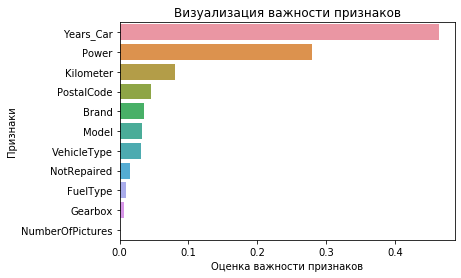

In [89]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_forest)

Как ожидаемо в случае с машинами, самым важным при цене является год выпуска и ее мощность.

## Вывод

В данном проекте необходимо было построить модель для определения стоимости. <div/>
В первую очередь были изучены исходные даные и проделаны следующие операции:
- проверили и удалили дубликаты;
- убрали строчки, где года были не корректны, до 1950 и после 2019;
- где строчки с мощностью, лошадинные силы, были равны нулю;
- заменили нули в колонке `Price` и значения `Nan` на маркер `unknown`;
- посчитали возраст автомобилей.<div/>
<div/> Были обучены 3 модели: RandomForestRegressor, LGBMRegressor и LinearRegression.
<div/> Хорошие результаты показали 2 модели RandomForestRegressor и LGBMRegressor. 
<div/> По скорости работы LGBMRegressor имеет приоритет, так как обучение происходит намного быстрее. Вероятнее это модели стоит отдать предпочтение.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей